In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras import regularizers
import os
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras as ks


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/merged_data.csv', index_col='ts', parse_dates=True)

In [ ]:
# Class weights calculation
neg, pos = np.bincount(dataset['anomaly_label'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
adjusted_weight_for_0 = weight_for_0 * 1.0  # Example: decrease if too many false positives
adjusted_weight_for_1 = weight_for_1 * 1.0  # Example: increase if too many false negatives

class_weight = {0: adjusted_weight_for_0, 1: adjusted_weight_for_1}
time_steps = 50  # Adjust based on your sequence length
batch_size = 128 # Adjust based on your batch size preference
output_size = 1

In [ ]:
# Split data function
def split_data_chronologically(data, test_ratio=0.2, val_ratio=0.2, target_column='anomaly_label'):
    total_samples = len(data)
    test_split_idx = int(total_samples * (1 - test_ratio))
    val_split_idx = int(test_split_idx * (1 - val_ratio / (1 - test_ratio)))

    train_data = data.iloc[:val_split_idx]
    val_data = data.iloc[val_split_idx:test_split_idx]
    test_data = data.iloc[test_split_idx:]

    return train_data, val_data, test_data

# Scale data function
def scale_data(train_data, val_data, test_data, target_column='anomaly_label'):
    scaler = StandardScaler()

    # Fit on training data
    train_features = train_data.drop(columns=[target_column])
    scaler.fit(train_features)

    # Transform features
    train_scaled = scaler.transform(train_features)
    val_scaled = scaler.transform(val_data.drop(columns=[target_column]))
    test_scaled = scaler.transform(test_data.drop(columns=[target_column]))

    # Extract labels
    train_labels = train_data[target_column].values
    val_labels = val_data[target_column].values
    test_labels = test_data[target_column].values

    return train_scaled, train_labels, val_scaled, val_labels, test_scaled, test_labels

# Create TensorFlow dataset function
def create_tf_dataset(features, labels, time_steps=100, batch_size=32, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=features,
        targets=np.roll(labels, -time_steps),
        sequence_length=time_steps,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return dataset

# Define metrics
METRICS = [
      ks.metrics.MeanSquaredError(name='MSE'),
      ks.metrics.TruePositives(name='tp'),
      ks.metrics.FalsePositives(name='fp'),
      ks.metrics.TrueNegatives(name='tn'),
      ks.metrics.FalseNegatives(name='fn'),
      ks.metrics.BinaryAccuracy(name='accuracy'),
      ks.metrics.Precision(name='precision'),
      ks.metrics.Recall(name='recall'),
      ks.metrics.AUC(name='auc'),
      ks.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
train_data, val_data, test_data = split_data_chronologically(dataset)
train_scaled, train_labels, val_scaled, val_labels, test_scaled, test_labels = scale_data(train_data, val_data, test_data)

    # Dataset Creation
train_dataset = create_tf_dataset(train_scaled, train_labels, time_steps=time_steps, batch_size=batch_size, shuffle=False)
val_dataset = create_tf_dataset(val_scaled, val_labels, time_steps=time_steps, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(test_scaled, test_labels, time_steps=time_steps, batch_size=batch_size, shuffle=False)
input_shape = (time_steps, train_scaled.shape[-1])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(train_dataset, epochs=50, batch_size=128,
                    validation_data=val_dataset, class_weight=class_weight)

# Evaluate the model
loss, accuracy, recall, precision = model.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)





Epoch 1/50


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Assuming you have trained your model and stored the training history in a variable called 'history'

# Save the trained model
model3.save("/content/drive/MyDrive/your_model2.keras")

# Save the training history
with open('/content/drive/MyDrive/history2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)

In [ ]:
# Define the CNN model
model2 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history1 = model2.fit(train_dataset, epochs=10, batch_size=128,
                    validation_data=val_dataset, class_weight=class_weight)







In [ ]:
# Evaluate the model
loss, accuracy, recall, precision = model2.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

5635/5635 [==============================] - 93s 17ms/step - loss: 0.7509 - accuracy: 0.6001 - recall: 0.6946 - precision: 0.4431
Test Loss: 0.7509377002716064
Test Accuracy: 0.6000632047653198
Test recall: 0.6946490406990051
Test precision: 0.44312527775764465


In [ ]:
# Define the CNN model
model3 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history2 = model3.fit(train_dataset, epochs=50, batch_size=128,
                    validation_data=val_dataset, class_weight=class_weight)







In [ ]:
# Evaluate the model
loss, accuracy, recall, precision = model3.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

5635/5635 [==============================] - 104s 18ms/step - loss: 0.7544 - accuracy: 0.6050 - recall_5: 0.6525 - precision_5: 0.4443
Test Loss: 0.7544416785240173
Test Accuracy: 0.605038046836853
Test recall: 0.6524998545646667
Test precision: 0.444283127784729


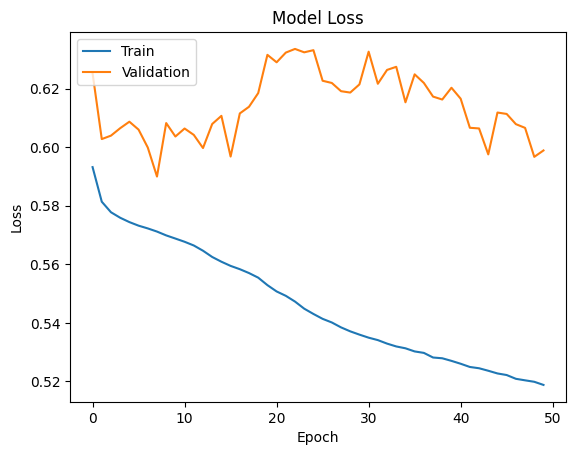

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here i adjusted the class weights to 0.5 to see what i would get


In [ ]:
# Define the CNN model
model4= Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history4 = model4.fit(train_dataset, epochs=10, batch_size=128,
                    validation_data=val_dataset, class_weight=class_weight)







Epoch 1/10
16905/16905 [==============================] - 531s 31ms/step - loss: 0.4187 - accuracy: 0.7234 - recall_7: 0.3295 - precision_7: 0.6039 - val_loss: 0.5251 - val_accuracy: 0.7565 - val_recall_7: 0.3879 - val_precision_7: 0.5318
Epoch 2/10
16905/16905 [==============================] - 473s 28ms/step - loss: 0.4177 - accuracy: 0.7196 - recall_7: 0.3441 - precision_7: 0.5861 - val_loss: 0.5301 - val_accuracy: 0.7038 - val_recall_7: 0.6080 - val_precision_7: 0.4419
Epoch 3/10
16905/16905 [==============================] - 475s 28ms/step - loss: 0.4161 - accuracy: 0.7206 - recall_7: 0.3461 - precision_7: 0.5888 - val_loss: 0.5213 - val_accuracy: 0.7178 - val_recall_7: 0.5720 - val_precision_7: 0.4579
Epoch 4/10
16905/16905 [==============================] - 448s 27ms/step - loss: 0.4150 - accuracy: 0.7214 - recall_7: 0.3568 - precision_7: 0.5882 - val_loss: 0.5180 - val_accuracy: 0.7130 - val_recall_7: 0.6076 - val_precision_7: 0.4537
Epoch 5/10
16905/16905 [====================

In [ ]:
# Evaluate the model
loss, accuracy, recall, precision = model4.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

5635/5635 [==============================] - 98s 17ms/step - loss: 0.6680 - accuracy: 0.6513 - recall_7: 0.5154 - precision_7: 0.4871
Test Loss: 0.667978048324585
Test Accuracy: 0.6513031721115112
Test recall: 0.515373945236206
Test precision: 0.4870762228965759


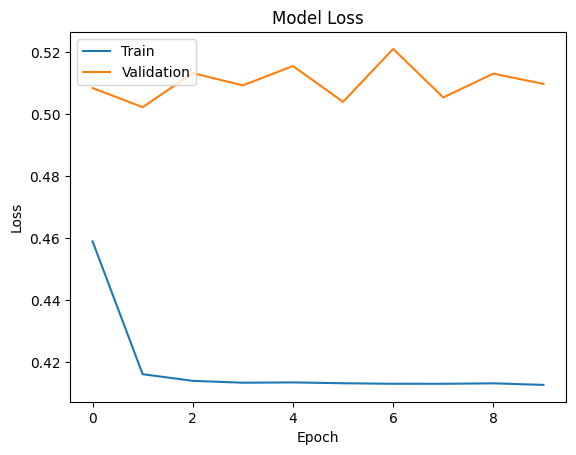

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

I tried to view the training without the class weights, to see the performance of the model , i only used 10 epochs to see how well it does

In [ ]:
# Define the CNN model
model5= Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history5 = model5.fit(train_dataset, epochs=10, batch_size=64,
                    validation_data=val_dataset)







Epoch 1/10
8453/8453 [==============================] - 419s 49ms/step - loss: 0.5411 - accuracy: 0.7212 - recall_16: 0.2918 - precision_16: 0.6111 - val_loss: 0.4960 - val_accuracy: 0.7678 - val_recall_16: 0.3583 - val_precision_16: 0.5723
Epoch 2/10
8453/8453 [==============================] - 414s 49ms/step - loss: 0.5267 - accuracy: 0.7330 - recall_16: 0.3611 - precision_16: 0.6245 - val_loss: 0.4975 - val_accuracy: 0.7684 - val_recall_16: 0.3979 - val_precision_16: 0.5662
Epoch 3/10
8453/8453 [==============================] - 415s 49ms/step - loss: 0.5245 - accuracy: 0.7333 - recall_16: 0.3665 - precision_16: 0.6234 - val_loss: 0.4907 - val_accuracy: 0.7711 - val_recall_16: 0.3754 - val_precision_16: 0.5799
Epoch 4/10
8453/8453 [==============================] - 417s 49ms/step - loss: 0.5228 - accuracy: 0.7342 - recall_16: 0.3700 - precision_16: 0.6251 - val_loss: 0.4845 - val_accuracy: 0.7753 - val_recall_16: 0.3402 - val_precision_16: 0.6071
Epoch 5/10
8453/8453 [==============

In [ ]:
loss, accuracy, recall, precision = model5.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

2818/2818 [==============================] - 91s 32ms/step - loss: 0.6654 - accuracy: 0.6894 - recall_16: 0.3192 - precision_16: 0.5767
Test Loss: 0.6653932332992554
Test Accuracy: 0.6894198060035706
Test recall: 0.3192481994628906
Test precision: 0.5767346024513245


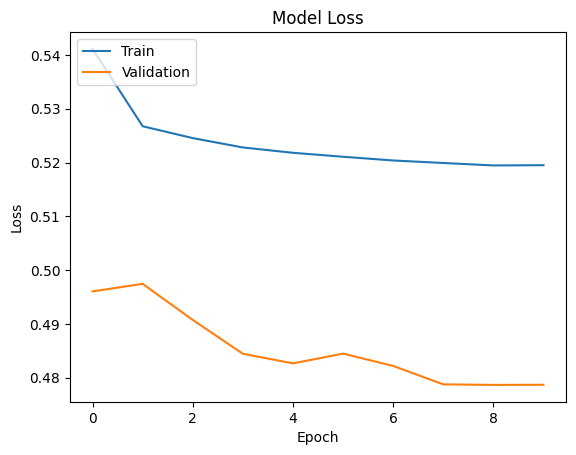

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here i first tried to implement the focal loss, but then i think the architecture was too complex and it ended up plateauing could also be that the learning rate was not good enough

In [ ]:
import keras_cv

Using TensorFlow backend


In [ ]:
pip install keras_cv

In [ ]:
# Define the CNN model
model6= Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=keras_cv.losses.FocalLoss(alpha=0.6, gamma=5),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history6 = model6.fit(train_dataset, epochs=30, batch_size=64,
                    validation_data=val_dataset)







Epoch 1/30
8453/8453 [==============================] - 442s 52ms/step - loss: 0.0090 - accuracy: 0.6888 - recall_24: 0.4451 - precision_24: 0.5014 - val_loss: 0.0082 - val_accuracy: 0.7470 - val_recall_24: 0.3884 - val_precision_24: 0.5059
Epoch 2/30
8453/8453 [==============================] - 432s 51ms/step - loss: 0.0086 - accuracy: 0.7189 - recall_24: 0.4943 - precision_24: 0.5555 - val_loss: 0.0081 - val_accuracy: 0.7092 - val_recall_24: 0.5947 - val_precision_24: 0.4478
Epoch 3/30
8453/8453 [==============================] - 428s 51ms/step - loss: 0.0085 - accuracy: 0.7230 - recall_24: 0.4905 - precision_24: 0.5645 - val_loss: 0.0081 - val_accuracy: 0.7368 - val_recall_24: 0.5471 - val_precision_24: 0.4863
Epoch 4/30
8453/8453 [==============================] - 429s 51ms/step - loss: 0.0085 - accuracy: 0.7232 - recall_24: 0.5037 - precision_24: 0.5630 - val_loss: 0.0080 - val_accuracy: 0.7489 - val_recall_24: 0.5055 - val_precision_24: 0.5084
Epoch 5/30
8453/8453 [==============

In [ ]:
loss, accuracy, recall, precision = model6.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

2818/2818 [==============================] - 92s 33ms/step - loss: 0.0099 - accuracy: 0.6279 - recall_24: 0.5842 - precision_24: 0.4619
Test Loss: 0.009872292168438435
Test Accuracy: 0.6278614401817322
Test recall: 0.5841820240020752
Test precision: 0.4618847966194153


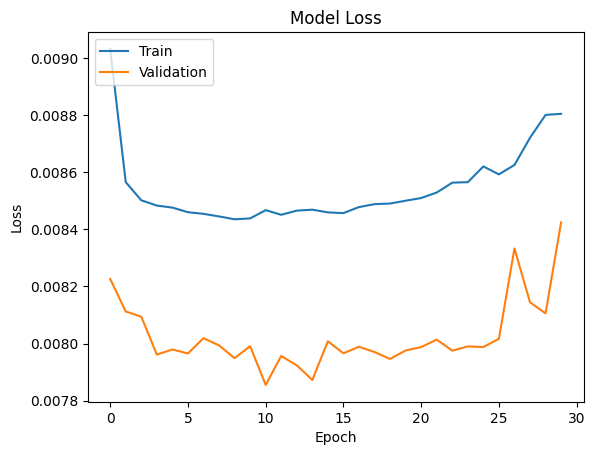

In [ ]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This model implements Focal cross entropy loss, that tries to put more emphasis on observations that are hard to classify, you can also specify the what class to put higher weights on

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Define the CNN model
model7 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras_cv.losses.FocalLoss(alpha=0.8),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history7 = model7.fit(train_dataset, epochs=10, batch_size=128,
                    validation_data=val_dataset)







Epoch 1/10
16905/16905 [==============================] - 452s 26ms/step - loss: 0.0747 - accuracy: 0.4215 - recall_4: 0.8629 - precision_4: 0.3344 - val_loss: 0.0577 - val_accuracy: 0.4368 - val_recall_4: 0.9449 - val_precision_4: 0.3052
Epoch 2/10
16905/16905 [==============================] - 428s 25ms/step - loss: 0.0573 - accuracy: 0.5024 - recall_4: 0.9072 - precision_4: 0.3765 - val_loss: 0.0566 - val_accuracy: 0.4610 - val_recall_4: 0.9397 - val_precision_4: 0.3143
Epoch 3/10
16905/16905 [==============================] - 440s 26ms/step - loss: 0.0564 - accuracy: 0.5104 - recall_4: 0.9127 - precision_4: 0.3811 - val_loss: 0.0556 - val_accuracy: 0.4842 - val_recall_4: 0.9252 - val_precision_4: 0.3223
Epoch 4/10
16905/16905 [==============================] - 432s 26ms/step - loss: 0.0559 - accuracy: 0.5170 - recall_4: 0.9129 - precision_4: 0.3845 - val_loss: 0.0548 - val_accuracy: 0.4976 - val_recall_4: 0.9203 - val_precision_4: 0.3277
Epoch 5/10
16905/16905 [====================

In [ ]:
history8 = model7.fit(train_dataset, epochs=20, batch_size=128,
                    validation_data=val_dataset)

In [ ]:
# Evaluate the model
loss, accuracy, recall, precision = model7.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

5635/5635 [==============================] - 97s 17ms/step - loss: 0.0728 - accuracy: 0.5304 - recall_4: 0.8208 - precision_4: 0.4053
Test Loss: 0.07278092205524445
Test Accuracy: 0.5304270386695862
Test recall: 0.8207943439483643
Test precision: 0.4053165912628174


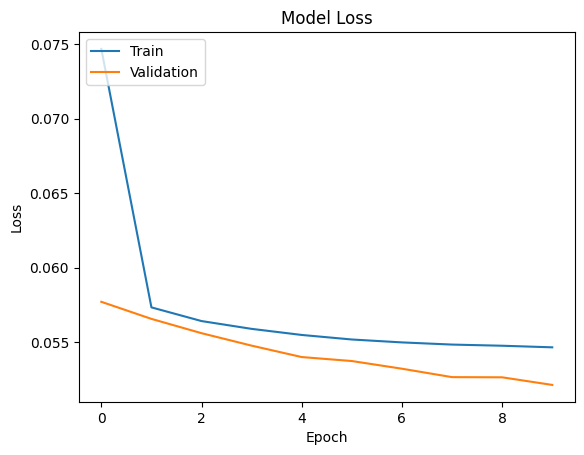

In [ ]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Assuming you have trained your model and stored the training history in a variable called 'history'

# Save the trained model
model7.save("/content/drive/MyDrive/soon_best.keras")

# Save the training history
with open('/content/drive/MyDrive/history7.pkl', 'wb') as file:
    pickle.dump(history2.history, file)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Define the CNN model
model9 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model with the desired optimizer, loss function, and metrics
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras_cv.losses.FocalLoss(alpha=0.7, gamma=7),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history9 = model9.fit(train_dataset, epochs=50, batch_size=128,
                    validation_data=val_dataset)

Epoch 1/50
16905/16905 [==============================] - 470s 28ms/step - loss: 0.0179 - accuracy: 0.5577 - recall_4: 0.4798 - precision_4: 0.3483 - val_loss: 0.0022 - val_accuracy: 0.4342 - val_recall_4: 0.7616 - val_precision_4: 0.2780
Epoch 2/50
16905/16905 [==============================] - 471s 28ms/step - loss: 0.0022 - accuracy: 0.6071 - recall_4: 0.6934 - precision_4: 0.4212 - val_loss: 0.0022 - val_accuracy: 0.4935 - val_recall_4: 0.9017 - val_precision_4: 0.3235
Epoch 3/50
16905/16905 [==============================] - 471s 28ms/step - loss: 0.0021 - accuracy: 0.6250 - recall_4: 0.7168 - precision_4: 0.4382 - val_loss: 0.0021 - val_accuracy: 0.5087 - val_recall_4: 0.9132 - val_precision_4: 0.3320
Epoch 4/50
16905/16905 [==============================] - 462s 27ms/step - loss: 0.0021 - accuracy: 0.6328 - recall_4: 0.7240 - precision_4: 0.4455 - val_loss: 0.0021 - val_accuracy: 0.5074 - val_recall_4: 0.9219 - val_precision_4: 0.3325
Epoch 5/50
16905/16905 [====================

In [ ]:
# Evaluate the model
loss, accuracy, recall, precision = model9.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test recall:", recall)
print("Test precision:", precision)

5635/5635 [==============================] - 94s 17ms/step - loss: 0.0027 - accuracy: 0.5997 - recall_4: 0.6821 - precision_4: 0.4419
Test Loss: 0.0026856474578380585
Test Accuracy: 0.5997374057769775
Test recall: 0.6821120977401733
Test precision: 0.4419257640838623


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Assuming you have trained your model and stored the training history in a variable called 'history'

# Save the trained model
model9.save("/content/drive/MyDrive/your_model9.keras")

# Save the training history
with open('/content/drive/MyDrive/history9.pkl', 'wb') as file:
    pickle.dump(history9.history, file)